# This Notebook is used to Forecast future Electricity Consumption using different variations of LSTM. We will then export the predictions of validated data to our dashboard.

## Load Packages & Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import os
import time

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from __future__ import print_function, division
from six import iteritems
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Activation, BatchNormalization
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.regularizers import l2

# Load Datasets

### Electricity

In [ ]:
file_path = "/content/drive/MyDrive/AA USD/AAI 530 IOT/IOT Project /data/electricity_cleaned.csv"
df_electricity = pd.read_csv(file_path)
print(df_electricity.shape)

df_electricity['DateTime'] = pd.to_datetime(df_electricity['DateTime'])
df_electricity.set_index('DateTime', inplace=True)
df_electricity.head()

(70080, 25)


,source,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 07:00:00,Electricity_I,883.2,59.1,30.0,794.1,0.0,197.9,0.0,0.0,23.7,...,6.0,6.8,0.0,19.8,0.0,24.5,0.0,0.0,30.0,4.8
2012-04-01 08:00:00,Electricity_I,769.7,57.9,30.0,681.8,0.0,6.0,0.0,0.0,23.8,...,6.0,6.0,0.0,5.6,0.0,22.1,0.0,0.0,27.8,3.8
2012-04-01 09:00:00,Electricity_I,707.0,59.2,30.0,617.8,0.0,6.0,0.0,0.0,23.7,...,6.0,6.0,0.0,0.0,0.0,11.5,0.0,0.0,28.8,5.6
2012-04-01 10:00:00,Electricity_I,709.8,56.6,30.0,623.2,0.0,6.0,0.0,0.0,24.0,...,6.0,6.0,0.0,0.0,0.0,29.1,0.0,0.0,27.9,5.3
2012-04-01 11:00:00,Electricity_I,782.0,61.9,30.0,690.1,0.0,6.0,0.0,0.0,23.6,...,6.0,6.0,0.0,0.0,0.0,19.1,0.2,0.0,28.3,3.7


In [ ]:
df_electricity['source'].unique()

array(['Electricity_I', 'Electricity_P', 'Electricity_Q', 'Electricity_S'],
      dtype=object)

In [ ]:
# Group the DataFrame by 'source' and create a separate DataFrame for each group
grouped = df_electricity.groupby('source')

# Creating a dictionary to hold each split DataFrame
dfs = {}
for name, group in grouped:
    dfs[name] = group

# Now, dfs is a dictionary where each key is a 'source' value and each value is the corresponding split DataFrame
# For example, to access the DataFrame for source 'Electricity_I', I can use:
df_electricity_i = dfs.get('Electricity_I')
df_electricity_p = dfs.get('Electricity_P')
df_electricity_q = dfs.get('Electricity_Q')
df_electricity_s = dfs.get('Electricity_S')

In [ ]:
df_electricity_s.head()

,source,WHE,RSE,GRE,MHE,B1E,BME,CWE,DWE,EQE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 07:00:00,Electricity_P,96515.0,5636.0,94.0,90785.0,0.0,23180.0,0.0,0.0,2389.0,...,2.0,571.0,0.0,1463.0,0.0,2934.0,248.0,0.0,2259.0,6095.0
2012-04-01 08:00:00,Electricity_P,74729.0,5543.0,78.0,69108.0,0.0,409.0,0.0,0.0,2398.0,...,1.0,448.0,0.0,581.0,0.0,2674.0,300.0,0.0,2272.0,3865.0
2012-04-01 09:00:00,Electricity_P,75663.0,5681.0,84.0,69898.0,0.0,411.0,0.0,0.0,2397.0,...,3.0,439.0,0.0,51.0,0.0,1420.0,300.0,0.0,2266.0,4811.0
2012-04-01 10:00:00,Electricity_P,75980.0,5426.0,70.0,70484.0,0.0,411.0,0.0,0.0,2415.0,...,0.0,445.0,0.0,7.0,0.0,3506.0,300.0,0.0,2264.0,4622.0
2012-04-01 11:00:00,Electricity_P,84123.0,6065.0,72.0,77986.0,0.0,411.0,0.0,0.0,2391.0,...,2.0,450.0,0.0,3.0,0.0,2345.0,317.0,0.0,2260.0,4136.0


### Weather

In [ ]:
file_path = "/content/drive/MyDrive/AA USD/AAI 530 IOT/IOT Project /data/weather_cleaned.csv"
df_weather = pd.read_csv(file_path)

# Set Date/Time as indext and rename
df_weather['Date/Time'] = pd.to_datetime(df_weather['Date/Time'])
df_weather.set_index('Date/Time', inplace=True)
df_weather.index.rename('DateTime', inplace=True)

print(df_weather.shape)
df_weather.head()

(17520, 6)


,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km)
DateTime,,,,,,
2012-04-01 00:00:00,87.0,2.3,99.88,28.0,4.3,12.9
2012-04-01 01:00:00,86.0,2.2,99.94,17.0,4.4,8.0
2012-04-01 02:00:00,86.0,1.6,100.00,26.0,3.8,6.4
2012-04-01 03:00:00,86.0,0.7,100.10,39.0,2.8,8.0
2012-04-01 04:00:00,87.0,0.4,100.23,30.0,2.4,9.7


# Append Datasets

In [ ]:
# Appending df_electricity_i to df_weather by matching DateTime indexes
df_appended = pd.concat([df_weather, df_electricity_s], axis=1, join='outer')
print(df_appended.shape)
df_appended.head(10)

(17527, 30)


,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),source,WHE,RSE,GRE,...,WOE,B2E,CDE,DNE,EBE,FGE,HTE,OUE,TVE,UNE
DateTime,,,,,,,,,,,,,,,,,,,,,
2012-04-01 00:00:00,87.0,2.3,99.88,28.0,4.3,12.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 01:00:00,86.0,2.2,99.94,17.0,4.4,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 02:00:00,86.0,1.6,100.00,26.0,3.8,6.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 03:00:00,86.0,0.7,100.10,39.0,2.8,8.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 04:00:00,87.0,0.4,100.23,30.0,2.4,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 05:00:00,86.0,0.9,100.37,35.0,3.0,9.7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 06:00:00,87.0,1.7,100.55,30.0,3.7,12.9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,Electricity_S,107450.0,7312.0,3781.0,...,122.0,980.0,0.0,2617.0,0.0,3325.0,541.0,0.0,3649.0,196.0
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,Electricity_S,87170.0,7246.0,3809.0,...,122.0,890.0,0.0,1103.0,0.0,3071.0,559.0,0.0,3561.0,45.0


### Drop the NAN's as they we can't backfill the values here.

In [ ]:
df_cleaned = df_appended.dropna()
print(df_cleaned.shape)
df_cleaned.head()

# Save the df_combined DataFrame to a CSV file
df_cleaned.to_csv("df_master.csv", index=True)

(17448, 30)


In [ ]:
df_cleaned.shape

(17448, 30)

#### Create Dataframes for certain areas of the house

In [ ]:
df_WHE = df_cleaned.drop(columns=['source','RSE', 'GRE', 'MHE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE', 'UNE'])
df_WHE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),WHE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,107450.0
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,87170.0


In [ ]:
df_RSE = df_cleaned.drop(columns=['source', 'WHE', 'GRE', 'MHE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE', 'UNE'])
df_RSE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),RSE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,7312.0
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,7246.0


In [ ]:
df_MHE = df_cleaned.drop(columns=['source', 'WHE','RSE', 'GRE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE', 'UNE'])
df_MHE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),MHE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,96357.0
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,76115.0


In [ ]:
df_UNE = df_cleaned.drop(columns=['source', 'WHE','RSE', 'GRE', 'MHE', 'B1E', 'BME', 'CWE', 'DWE', 'EQE', 'FRE', 'HPE',
                                  'OFE', 'UTE', 'WOE', 'B2E', 'CDE', 'DNE', 'EBE', 'FGE', 'HTE', 'OUE','TVE'])
df_UNE.head(2)

,Rel Hum (%),Dew Point Temp (C),Stn Press (kPa),Wind Spd (km/h),Temp (C),Visibility (km),UNE
DateTime,,,,,,,
2012-04-01 07:00:00,79.0,1.3,100.74,24.0,4.7,16.1,196.0
2012-04-01 08:00:00,75.0,1.3,100.94,20.0,5.3,24.1,45.0


# LSTM Model for WHE against Electricity Data

In [ ]:
# Choose the Whole House 'WHE' for the predictor

df_WHE = df_cleaned['WHE']
df_WHE.head(2)



DateTime
2012-04-01 07:00:00    107450.0
2012-04-01 08:00:00     87170.0
Name: WHE, dtype: float64

In [ ]:
df = df_WHE.drop(columns=['DateTime'])
df.head()

DateTime
2012-04-01 07:00:00    107450.0
2012-04-01 08:00:00     87170.0
2012-04-01 09:00:00     87020.0
2012-04-01 10:00:00     87288.0
2012-04-01 11:00:00     96294.0
Name: WHE, dtype: float64

## Split data, scale it and create train & validation sets

In [ ]:
#assign size for data subset
df_size = round(len(df)/2)
print(df_size)

start = 0
df_small = df.iloc[start:start+df_size].reset_index()

# Exclude non-numeric columns
numeric_columns = df_small.select_dtypes(include=[np.number]).columns

# Standardize the data
scaler = StandardScaler()
df_small[numeric_columns] = scaler.fit_transform(df_small[numeric_columns])

# Split data subset 80/20 for train/validation
split_point = round(len(df_small) * 0.8)
train_df = df_small.iloc[:split_point]
val_df = df_small.iloc[split_point:]

print("train size: ", train_df.shape)
print("validation size: ", val_df.shape)

8724
train size:  (6979, 2)
validation size:  (1745, 2)


In [ ]:
train_df.head()

,DateTime,WHE
0,2012-04-01 07:00:00,0.734593
1,2012-04-01 08:00:00,0.230694
2,2012-04-01 09:00:00,0.226967
3,2012-04-01 10:00:00,0.233626
4,2012-04-01 11:00:00,0.457399


In [ ]:
#reset the indices for cleanliness
train_df = train_df.reset_index()
train_df = train_df.drop(columns=['DateTime'])

val_df = val_df.reset_index()
val_df = val_df.drop(columns=['DateTime'])

# Create Functions for Modeling
This function is used to convert the dataframe into sequences of data that the LSTM model can train on.

In [ ]:
seq_arrays = []
seq_labs = []

# we'll start out with a 2 week past hourly inputsinput sequence and an hour ahead predictive horizon
seq_length = 336
ph = 1
feat_cols = ['WHE']

#create list of sequence length GAP readings
for start in range(0,len(train_df)-seq_length-ph):
  seq_arrays.append(train_df[feat_cols].iloc[start:start+seq_length].to_numpy())
  seq_labs.append(train_df['WHE'].iloc[start+seq_length+ph-1]) # subtract 1 for zero-indexing

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays, dtype = object).astype(np.float32)
seq_labs = np.array(seq_labs, dtype = object).astype(np.float32)

assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length,len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))


### Data Preprocessing

### Building the LSTM Model

Below I presented several model architectures and evaluated them against their Validation performances. The first one achieved an 0.843, 2nd was 0.79, thirdd was 0.98, and 4th was 0.76

In [ ]:
# 0.843

# # define path to save model
# model_path = 'LSTM_model1.h5'

# # build the network
# nb_features = len(feat_cols)
# nb_out = 1

# # Define the model
# model = Sequential()

# # Add the first LSTM layer with dropout
# model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, nb_features)))
# model.add(Dropout(0.3))

# # Add a second LSTM layer with dropout
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.3))

# # Add a third LSTM layer with dropout
# model.add(LSTM(units=32, return_sequences=False))
# model.add(Dropout(0.3))

# # Add the Dense layer with linear activation
# model.add(Dense(units=nb_out))
# model.add(Activation('linear'))

# optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
# # optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# # optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 168, 128)          66560     
                                                                 
 dropout_18 (Dropout)        (None, 168, 128)          0         
                                                                 
 lstm_19 (LSTM)              (None, 168, 64)           49408     
                                                                 
 dropout_19 (Dropout)        (None, 168, 64)           0         
                                                                 
 lstm_20 (LSTM)              (None, 32)                12416     
                                                                 
 dropout_20 (Dropout)        (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 1)                

In [ ]:
# 0.790
# define path to save model
# model_path = 'LSTM_model1.h5'

# # build the network
# nb_features = len(feat_cols)
# nb_out = 1

# model = Sequential()

# # First LSTM layer
# model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, nb_features)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))  # Adjusted dropout rate

# # Second LSTM layer
# model.add(LSTM(units=64, return_sequences=True))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  # Adjusted dropout rate

# # Third LSTM layer
# model.add(LSTM(units=32, return_sequences=False))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))  # Kept the dropout rate

# # Output layer
# model.add(Dense(units=1))
# model.add(Activation('linear'))

# # Choose an optimizer
# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# # optimizer = optimizers.SGD(learning_rate=0.001, momentum=0.9)
# # optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9)

# model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# print(model.summary())

In [ ]:
# #0.98
# # build the network
# nb_features = len(feat_cols)
# nb_out = 1

# model = Sequential()

# # First LSTM layer with L2 regularization
# model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, nb_features), kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))  # Adjusted dropout rate

# # Second LSTM layer with L2 regularization
# model.add(LSTM(units=64, return_sequences=True, kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.25))  # Adjusted dropout rate

# # Third LSTM layer with L2 regularization
# model.add(LSTM(units=32, return_sequences=False, kernel_regularizer=l2(0.01)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))  # Kept the dropout rate

# # Output layer with L2 regularization
# model.add(Dense(units=nb_out, kernel_regularizer=l2(0.01)))
# model.add(Activation('linear'))

# optimizer = keras.optimizers.Adam(learning_rate=0.0001)
# model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mse'])

# print(model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_27 (LSTM)              (None, 168, 128)          66560     
                                                                 
 batch_normalization_6 (Bat  (None, 168, 128)          512       
 chNormalization)                                                
                                                                 
 dropout_27 (Dropout)        (None, 168, 128)          0         
                                                                 
 lstm_28 (LSTM)              (None, 168, 64)           49408     
                                                                 
 batch_normalization_7 (Bat  (None, 168, 64)           256       
 chNormalization)                                                
                                                                 
 dropout_28 (Dropout)        (None, 168, 64)          

In [ ]:
#0.76
#define path to save model
model_path = 'LSTM_model1.h5'

# build the network
nb_features = len(feat_cols)
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=20,
         return_sequences=True))
model.add(Dropout(0.3))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.3))

# Add the Dense layer with linear activation
model.add(Dense(units=nb_out))
model.add(Activation('linear'))

optimizer = keras.optimizers.Adamax(learning_rate = 0.001)
# optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
#optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# print(model.summary())

In [ ]:
# #0.77
# #define path to save model
# model_path = 'LSTM_model1.h5'

# # build the network
# nb_features = len(feat_cols)
# nb_out = 1

# model = Sequential()

# # Add the first LSTM layer with dropout
# model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, nb_features)))
# model.add(Dropout(0.3))

# # Add a second LSTM layer with dropout
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.3))

# # Add a third LSTM layer with dropout
# model.add(LSTM(units=32, return_sequences=False))
# model.add(Dropout(0.3))

# # Add the Dense layer with linear activation
# model.add(Dense(units=nb_out))
# model.add(Activation('linear'))

# optimizer = keras.optimizers.Adam(learning_rate = 0.01)
# # optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# #optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# print(model.summary())

In [ ]:
# #0.86
# #define path to save model
# model_path = 'LSTM_model1.h5'

# # build the network
# nb_features = len(feat_cols)
# nb_out = 1

# model = Sequential()

# # Add the first LSTM layer with dropout
# model.add(LSTM(units=128, return_sequences=True, input_shape=(seq_length, nb_features)))
# model.add(Dropout(0.3))

# # Add a second LSTM layer with dropout
# model.add(LSTM(units=64, return_sequences=True))
# model.add(Dropout(0.3))

# # Add a third LSTM layer with dropout
# model.add(LSTM(units=32, return_sequences=False))
# model.add(Dropout(0.3))

# # Add the Dense layer with linear activation
# model.add(Dense(units=nb_out))
# model.add(Activation('linear'))

# optimizer = keras.optimizers.Adam(learning_rate = 0.001)
# # optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)
# #optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
# model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

# print(model.summary())

In [ ]:

# fit the network
history = model.fit(seq_arrays, seq_labs, epochs=1000, batch_size=64,validation_split=0.2, verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                                               min_delta=0, patience=30, verbose=0, mode='min'),
                                 keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True,mode='min', verbose=0)]
)
# list all data in history
print(history.history.keys())

Epoch 1/1000
84/84 - 6s - loss: 0.8080 - mse: 0.8080 - val_loss: 1.3398 - val_mse: 1.3398 - 6s/epoch - 74ms/step
Epoch 2/1000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 - 3s - loss: 0.7843 - mse: 0.7843 - val_loss: 1.3095 - val_mse: 1.3095 - 3s/epoch - 33ms/step
Epoch 3/1000
84/84 - 2s - loss: 0.7699 - mse: 0.7699 - val_loss: 1.2681 - val_mse: 1.2681 - 2s/epoch - 24ms/step
Epoch 4/1000
84/84 - 2s - loss: 0.7522 - mse: 0.7522 - val_loss: 1.2166 - val_mse: 1.2166 - 2s/epoch - 23ms/step
Epoch 5/1000
84/84 - 2s - loss: 0.7288 - mse: 0.7288 - val_loss: 1.1788 - val_mse: 1.1788 - 2s/epoch - 25ms/step
Epoch 6/1000
84/84 - 2s - loss: 0.7196 - mse: 0.7196 - val_loss: 1.1514 - val_mse: 1.1514 - 2s/epoch - 23ms/step
Epoch 7/1000
84/84 - 2s - loss: 0.7079 - mse: 0.7079 - val_loss: 1.1343 - val_mse: 1.1343 - 2s/epoch - 23ms/step
Epoch 8/1000
84/84 - 3s - loss: 0.7002 - mse: 0.7002 - val_loss: 1.1190 - val_mse: 1.1190 - 3s/epoch - 33ms/step
Epoch 9/1000
84/84 - 2s - loss: 0.6962 - mse: 0.6962 - val_loss: 1.1110 - val_mse: 1.1110 - 2s/epoch - 26ms/step
Epoch 10/1000
84/84 - 2s - loss: 0.6948 - mse: 0.6948 - val_loss: 1.0994 - val_mse: 1.0994 - 2s/epoch - 24ms/

### Evaluate

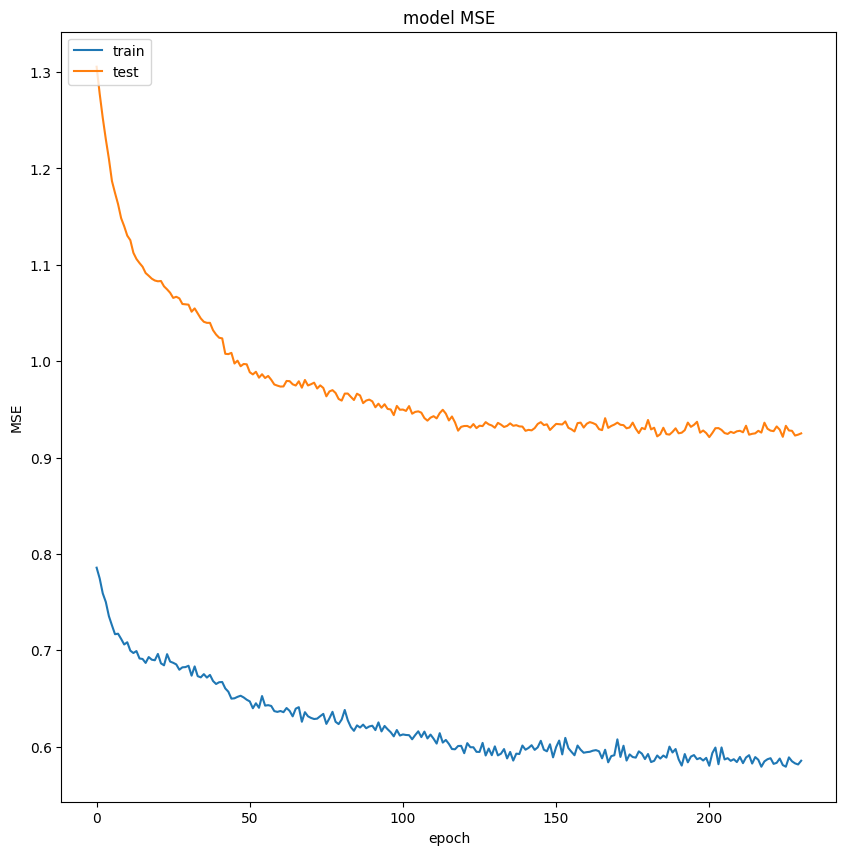

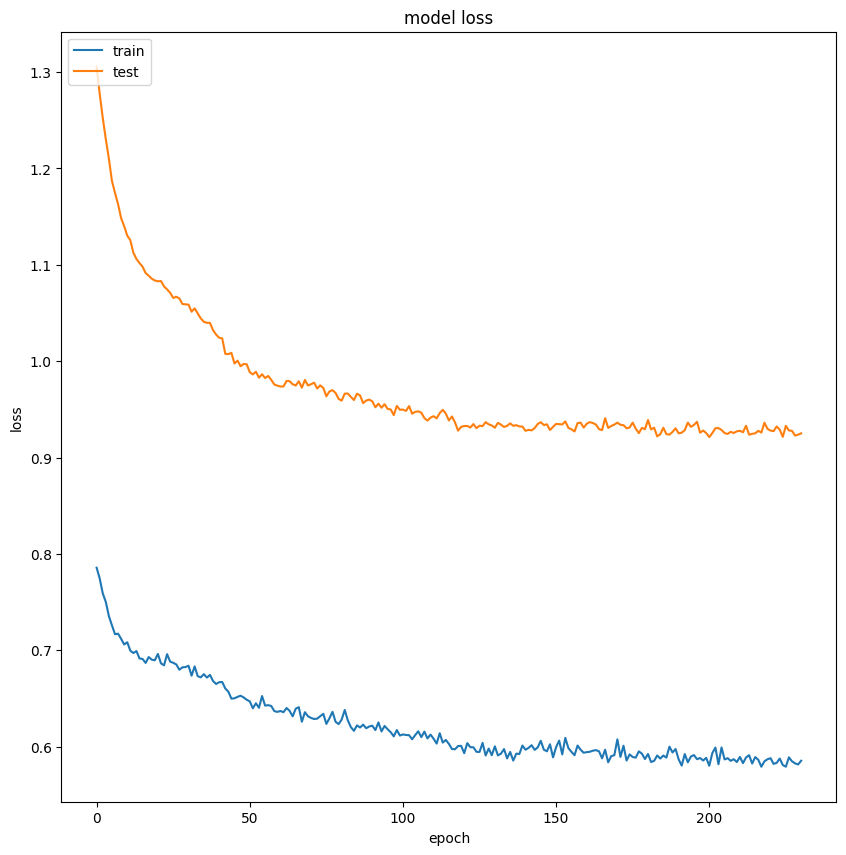

In [ ]:
# summarize history for MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model MSE')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_mse1.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")

In [ ]:
val_arrays = []
val_labs = []

#create list of readings starting with a minimum of two readings
for i in range(2, len(val_df) - ph + 1):
    # Correctly reference the single column and convert it to a list
    input_seq = val_df[feat_cols].iloc[i-2:i+seq_length-ph].to_numpy().tolist()
    # Ensure we have a label available at the predictive horizon
    if i + seq_length - ph <= len(val_df):
        label = val_df[feat_cols].iloc[i+seq_length-ph-1]
        val_labs.append(label)
        val_arrays.append(input_seq)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
# Pad sequences to ensure uniform length, using 'pre' padding
val_arrays_padded = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre', value=0.0)
val_arrays =val_arrays_padded

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs, dtype = object).astype(np.float32)

In [ ]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Rescale the predicted and true values back to the original scale
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_true_test_rescaled = scaler.inverse_transform(y_true_test)



test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)


45/45 - 1s - loss: 0.7648 - mse: 0.7648 - 1s/epoch - 32ms/step

MSE: 0.7648045420646667
45/45 [==============================] - 1s 10ms/step


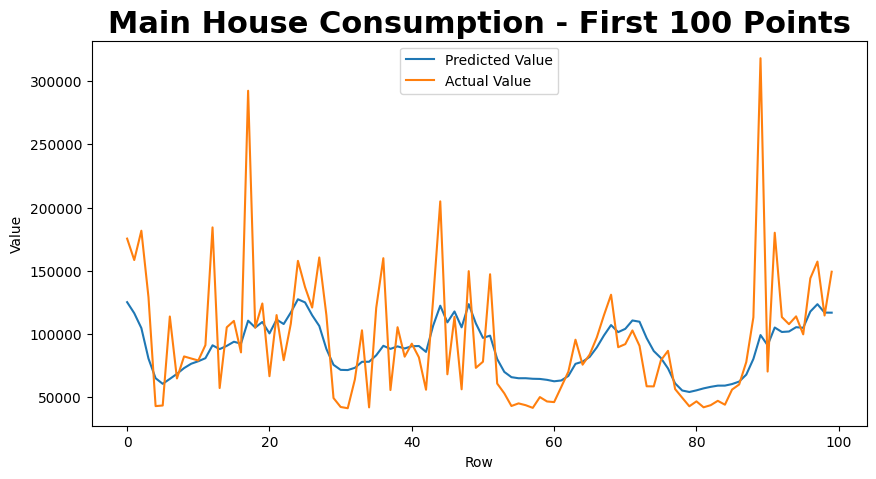

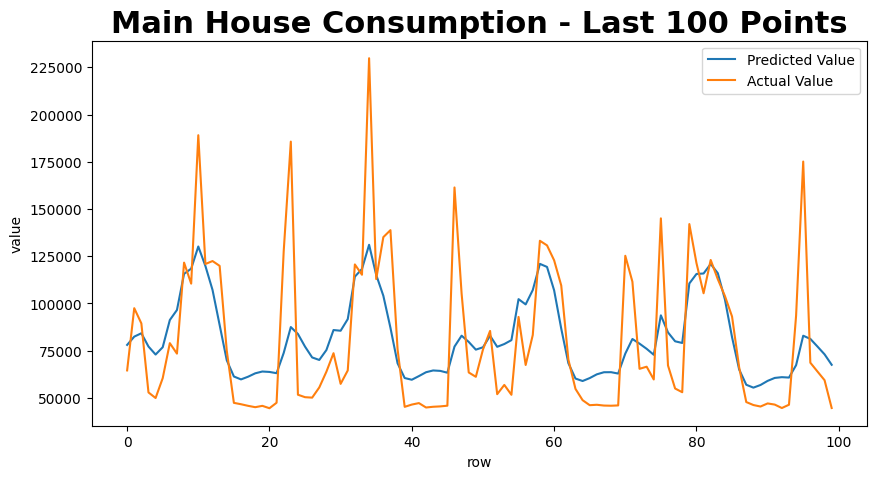

In [ ]:
# We will limit our plot to the first 100 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_rescaled[:100], label='Predicted Value')
plt.plot(y_true_test_rescaled[:100], label='Actual Value')
plt.title('Main House Consumption - First 100 Points', fontsize=22, fontweight='bold')
plt.ylabel('Value')
plt.xlabel('Row')
plt.legend()
plt.show()
fig_verify.savefig("Electicity LSTM Model 0.76 MSE First 100.png")

# last 100 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test_rescaled[-100:], label = 'Predicted Value')
plt.plot(y_true_test_rescaled[-100:], label = 'Actual Value')
plt.title('Main House Consumption - Last 100 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("Electicity LSTM Model 0.76 MSE Last 100.png")

#### We will rescale our data and the combine them into a combined datframe for our dashboard

In [ ]:
# Inverse transform to rescale the data back to the original scale
train_rescaled = scaler.inverse_transform(train_df)
val_rescaled = scaler.inverse_transform(val_df)

# Convert the rescaled arrays back to DataFrames
train_rescaled_df = pd.DataFrame(train_rescaled, columns=['DateTime','Apparent Power'])
val_rescaled_df = pd.DataFrame(val_rescaled, columns=['DateTime','Apparent Power'])

# Concatenate the rescaled train and validation dataframes
df_combined = pd.concat([train_rescaled_df, val_rescaled_df])

# Recreate the DateTime index for the combined dataframe
# This assumes your data was hourly and the first DateTime was '2012-04-01 07:00:00'
start_datetime = pd.to_datetime('2012-04-01 07:00:00')
date_range = pd.date_range(start=start_datetime, periods=len(df_combined), freq='H')

# Assign the DateTime to the combined dataframe
df_combined['DateTime'] = date_range
df_combined.set_index('DateTime', inplace=True)

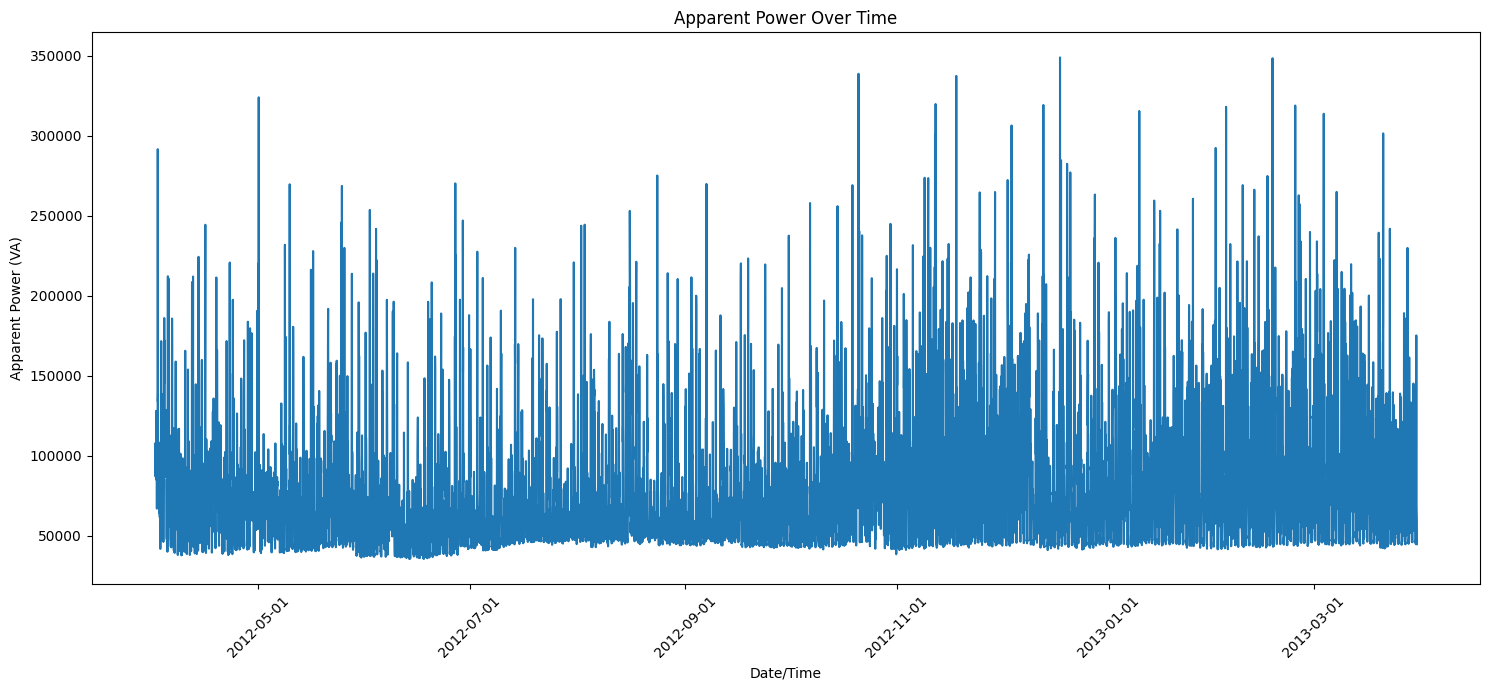

In [ ]:
# Now, plot the 'Apparent Power' for whole dataset
plt.figure(figsize=(15, 7))
plt.plot(df_combined.index, df_combined['Apparent Power'], color='tab:blue')

plt.title('Apparent Power Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Apparent Power (VA)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()

# Rebuild Dataframe with Original and Validation

In [ ]:
# Predictions on validation data
y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

# Rescale the predicted and true values back to the original scale
y_pred_test_rescaled = scaler.inverse_transform(y_pred_test)
y_true_test_rescaled = scaler.inverse_transform(y_true_test)

45/45 [==============================] - 1s 15ms/step


In [ ]:
predictions = model.predict(val_arrays)

# Inverse scale the predictions
predictions_rescaled = scaler.inverse_transform(predictions)

# Create a DataFrame for the rescaled predictions
predictions_df = pd.DataFrame(predictions_rescaled, columns=['Predictions'])

# Determine the correct indices in df_combined for the predictions
# We align these from the end of the df_combined DataFrame
prediction_indices = df_combined.index[-len(predictions_df):]

# Assign these indices to the predictions DataFrame
predictions_df.index = prediction_indices

# Append the predictions DataFrame to the df_combined DataFrame
# Since you're appending from the end, you need to ensure the indices match correctly
df_combined.loc[predictions_df.index, 'Predictions'] = predictions_df['Predictions']

45/45 [==============================] - 1s 15ms/step


In [ ]:
prediction_indices

DatetimeIndex(['2013-01-31 02:00:00', '2013-01-31 03:00:00',
               '2013-01-31 04:00:00', '2013-01-31 05:00:00',
               '2013-01-31 06:00:00', '2013-01-31 07:00:00',
               '2013-01-31 08:00:00', '2013-01-31 09:00:00',
               '2013-01-31 10:00:00', '2013-01-31 11:00:00',
               ...
               '2013-03-30 09:00:00', '2013-03-30 10:00:00',
               '2013-03-30 11:00:00', '2013-03-30 12:00:00',
               '2013-03-30 13:00:00', '2013-03-30 14:00:00',
               '2013-03-30 15:00:00', '2013-03-30 16:00:00',
               '2013-03-30 17:00:00', '2013-03-30 18:00:00'],
              dtype='datetime64[ns]', name='DateTime', length=1409, freq=None)

# Export our combine dataframe for the Dashboard

In [ ]:
# Save the df_combined DataFrame to a CSV file
df_combined.to_csv("df_combined.csv", index=True)


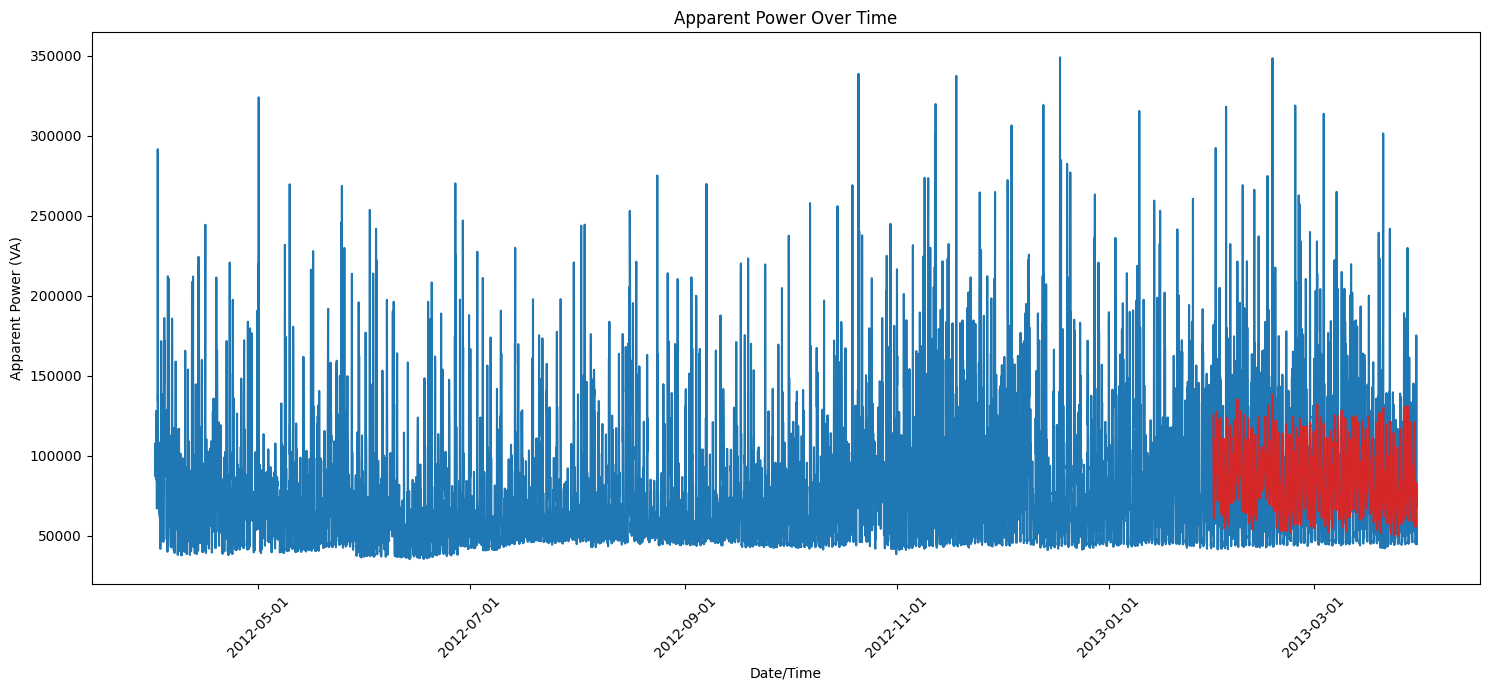

In [ ]:
# plot the 'Temp (C)' for Train & Validation
plt.figure(figsize=(15, 7))
plt.plot(df_combined.index, df_combined['Apparent Power'], color='tab:blue')
plt.plot(df_combined.index, df_combined['Predictions'], color='tab:red')
plt.title('Apparent Power Over Time')
plt.xlabel('Date/Time')
plt.ylabel('Apparent Power (VA)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.tight_layout()